In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres

In [3]:
def exchange_rows(A):
    r, c = A.shape
    A1 = np.zeros((r, c))
    for i in range(0, r):
        A1[i] = A[-i -1]
    
    return A1

In [9]:
def tdma_gmres(c_diag, t_diag, b_diag, B):
    
    tdma = np.diag(c_diag, k=0) + np.diag(b_diag[1:], k=-1) + np.diag(t_diag[:-1], k=1)
    sol = gmres(tdma, B)[0]
    
    return sol

In [4]:
def tdma_solver(c_diag, t_diag, b_diag, B):
    
    #print(c_diag, '\n')
    #print(t_diag, '\n')
    #print(b_diag, '\n')
    
    tdma = np.diag(c_diag, k=0) + np.diag(b_diag[1:], k=-1) + np.diag(t_diag[:-1], k=1)
    sol = np.linalg.solve(tdma, B)
    
    return sol

In [5]:
def solve_X(u, aP, aE, aW, aN, aS, p, r_sweeps, c_sweeps, alpha_uv, del_y, del_x, u_lid, mu):
    
    sol_dim = aP.shape
    
    rows = np.flip(np.arange(sol_dim[0]), axis = 0)
    #rows = np.arange(sol_dim[0])
    columns = np.arange(sol_dim[1])
    
    rc_sweeps = r_sweeps + c_sweeps
    sweep = 0
    
    # row-wise sweeps.....................
    
    while sweep < rc_sweeps:
        
        for i in rows:
            
            c_diag = np.zeros(aP.shape[1])
            t_diag = np.zeros(aP.shape[1])
            b_diag = np.zeros(aP.shape[1])
            Sc = np.zeros(aP.shape[1])
            Sp = np.zeros(aP.shape[1])

            if i == 0: # top row

                for j in columns:

                        if j == 0: # top left corner u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aS[i, j]*u[i + 1, j + 1] - aW[i, j]*u[i, j]

                            # source with correction form
                            Sc[j] =  Sc[j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 8.*u_lid*mu*del_x/(3.*del_y)


                        elif j >= 1 and j < sol_dim[1] - 1: # top inner u cells

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]
                            b_diag[j] = aW[i, j]
                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aS[i, j]*u[i + 1, j + 1]

                            # source with correction form
                            Sc[j] =  Sc[j] - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 8.*u_lid*mu*del_x/(3.*del_y)
                            

                        elif j == sol_dim[1] - 1: # top right corner u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            b_diag[j] = aW[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aS[i, j]*u[i + 1, j + 1] - aE[i, j]*u[i, j + 2]

                            # source with correction form
                            Sc[j] = Sc[j] - aW[i, j]*u[i, j] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 8.*u_lid*mu*del_x/(3.*del_y)

                # solve for u
                U = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                u[i, 1:-1] = u[i, 1:-1] + U[:] # update in a correction form way


            elif i == sol_dim[0] - 1: # bottom row

                for j in columns:

                        if j == 0: # bottom left corner u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1] - aW[i, j]*u[i, j]

                            # source with correction form
                            Sc[j] = Sc[j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.


                        elif j >= 1 and j < sol_dim[1] - 1: # bottom inner u cells

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]
                            b_diag[j] = aW[i, j]
                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1]

                            # source with correction form
                            Sc[j] = Sc[j] - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.
                            

                        elif j == sol_dim[1] - 1: # bottom right corner u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            b_diag[j] = aW[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1] - aE[i, j]*u[i, j + 2]

                            # source with correction form
                            Sc[j] = Sc[j] - aW[i, j]*u[i, j] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.

                # solve for u
                U = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                u[i, 1:-1] = u[i, 1:-1] + U[:] # update in a correction form way


            else: # all interior rows

                for j in columns:

                        if j == 0: # left u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1] - \
                                                                      aS[i, j]*u[i + 1, j + 1] - aW[i, j]*u[i, j]

                            # source with correction form
                            Sc[j] = Sc[j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.


                        elif j >= 1 and j < sol_dim[1] - 1: # inner u cells

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            t_diag[j] = aE[i, j]
                            b_diag[j] = aW[i, j]
                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1] - \
                                                                      aS[i, j]*u[i + 1, j + 1]

                            # source with correction form
                            Sc[j] = Sc[j] - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.

                        elif j == sol_dim[1] - 1: # right u cell

                            c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                            b_diag[j] = aW[i, j]

                            # standard source
                            Sc[j] = del_y * (p[i, j] - p[i, j + 1]) - aN[i, j]*u[i - 1, j - 1] - \
                                                                      aS[i, j]*u[i + 1, j + 1] - \
                                                                      aE[i, j]*u[i, j + 2]

                            # source with correction form
                            Sc[j] = Sc[j] - aW[i, j]*u[i, j] - aP[i, j]*u[i, j + 1]

                            # extra source from B.C.
                            Sp[j] = 0.

                # solve for u
                U = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                u[i, 1:-1] = u[i, 1:-1] + U[:] # update in a correction form way
                
        
        # column-wise sweep....................
        
        for j in columns:
            
            c_diag = np.zeros(aP.shape[0])
            t_diag = np.zeros(aP.shape[0])
            b_diag = np.zeros(aP.shape[0])
            Sc = np.zeros(aP.shape[0])
            Sp = np.zeros(aP.shape[0])

            if j == 0: # left column

                for i in rows:

                    if i == 0: # top left corner u cell
                        
                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 8.*u_lid*mu*del_x/(3.*del_y)


                    elif i >= 1 and i < sol_dim[0] - 1: # left inner u cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]
                        b_diag[i] = aS[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom left corner u cell
                        
                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for u
                U = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                u[:, j + 1] = u[:, j + 1] + np.flip(U[:],0) # update in a correction form way


            elif j == sol_dim[1] - 1: # right column

                for i in rows:

                    if i == 0: # top right u cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 8.*u_lid*mu*del_x/(3.*del_y)


                    elif i >= 1 and i < sol_dim[0] - 1: # right inner u cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]
                        t_diag[i] = aN[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom right u cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for u
                U = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                u[:, j + 1] = u[:, j + 1] + np.flip(U[:],0) # update in a correction form way

            else: # all interior columns

                for i in rows:

                    if i == 0: # top u cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 8.*u_lid*mu*del_x/(3.*del_y)


                    elif i >= 1 and i < sol_dim[0] - 1: # inner u cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]
                        t_diag[i] = aN[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aE[i, j]*u[i, j + 2] - aW[i, j]*u[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*u[i + 1, j + 1] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom u cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i, j] - p[i, j + 1]) - aW[i, j]*u[i, j] - aE[i, j]*u[i, j + 2]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*u[i - 1, j - 1] - aP[i, j]*u[i, j + 1]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for u
                U = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                u[:, j + 1] = u[:, j + 1] + np.flip(U[:],0) # update in a correction form way
                
        
        sweep += 1
    
    
    return u

In [6]:
def solve_Y(v, aP, aE, aW, aN, aS, p, r_sweeps, c_sweeps, alpha_uv, del_y, del_x, mu):
    
    sol_dim = aP.shape
    #rows = np.arange(sol_dim[0])
    rows = np.flip(np.arange(sol_dim[0]), axis = 0)
    columns = np.arange(sol_dim[1])
    
    rc_sweeps = r_sweeps + c_sweeps
    sweep = 0
    
    # row wise sweeps..........
    
    while sweep < rc_sweeps:
        
        for i in rows:
            
            c_diag = np.zeros(aP.shape[1])
            t_diag = np.zeros(aP.shape[1])
            b_diag = np.zeros(aP.shape[1])
            Sc = np.zeros(aP.shape[1])
            Sp = np.zeros(aP.shape[1])

            if i == 0: # top row

                for j in columns:

                    if j == 0: # top left corner v cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]

                        #standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j]
                            
                        # source with correction form
                        Sc[j] = Sc[j] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]
                            
                        # extra source from B.C.
                        Sp[j] = 0.


                    elif j >= 1 and j < sol_dim[1] - 1: # top inner v cells

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                    elif j == sol_dim[1] - 1: # top right corner u cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                # solve for v
                V = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                v[i + 1, :] = v[i + 1, :] + V[:] # update in a correction form way


            elif i == sol_dim[0] - 1: # bottom row

                for j in columns:

                    if j == 0: # bottom left corner v cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]

                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.


                    elif j >= 1 and j < sol_dim[1] - 1: # bottom inner v cells

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                    elif j == sol_dim[1] - 1: # bottom right corner v cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                # solve for v
                V = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                v[i + 1, :] = v[i + 1, :] + V[:] # update in a correction form way


            else: # all interior rows

                for j in columns:

                    if j == 0: # left v cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]

                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.


                    elif j >= 1 and j < sol_dim[1] - 1: # inner v cells

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aE[i, j]*v[i + 1, j + 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                    elif j == sol_dim[1] - 1: # right v cell

                        c_diag[j] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[j] = Sc[j] - aW[i, j]*v[i + 1, j - 1] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[j] = 0.

                # solve for v
                V = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                v[i + 1, :] = v[i + 1, :] + V[:] # update in a correction form way
                
        
        # column wise sweeps.................
        
        for j in columns:
            
            c_diag = np.zeros(aP.shape[0])
            t_diag = np.zeros(aP.shape[0])
            b_diag = np.zeros(aP.shape[0])
            Sc = np.zeros(aP.shape[0])
            Sp = np.zeros(aP.shape[0])

            if j == 0: # left column

                for i in rows:

                    if i == 0: # top left corner v cell
                        
                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aN[i, j]*v[i, j] - aE[i, j]*v[i + 1, j + 1]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.


                    elif i >= 1 and i < sol_dim[0] - 1: # left inner v cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]
                        t_diag[i] = aN[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aE[i, j]*v[i + 1, j + 1]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom left corner v cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aE[i, j]*v[i + 1, j + 1] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*v[i, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for v
                V = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                v[1:-1, j] = v[1:-1, j] + np.flip(V[:],0) # update in a correction form way


            elif j == sol_dim[1] - 1: # right column

                for i in rows:

                    if i == 0: # top right v cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aW[i, j]*v[i + 1, j - 1] - aN[i, j]*v[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.


                    elif i >= 1 and i < sol_dim[0] - 1: # right inner v cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]
                        t_diag[i] = aN[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aW[i, j]*v[i + 1, j - 1]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom right v cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aW[i, j]*v[i + 1, j - 1] - aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*v[i, j] - aP[i, j]*v[i +1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for v
                V = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                v[1:-1, j] = v[1:-1, j] + np.flip(V[:],0) # update in a correction form way

            else: # all interior columns

                for i in rows:

                    if i == 0: # top v cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aE[i, j]*v[i + 1, j + 1] - \
                                                                  aW[i, j]*v[i + 1, j - 1] - \
                                                                  aN[i, j]*v[i, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.


                    elif i >= 1 and i < sol_dim[0] - 1: # inner v cells

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        b_diag[i] = aS[i, j]
                        t_diag[i] = aN[i, j]
                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aE[i, j]*v[i + 1, j + 1] - aW[i, j]*v[i + 1, j - 1]

                        # source with correction form
                        Sc[i] = Sc[i] - aS[i, j]*v[i + 2, j] - aN[i, j]*v[i, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                    elif i == sol_dim[0] - 1: # bottom v cell

                        c_diag[i] = (1. + alpha_uv) * aP[i, j] # correction form
                        t_diag[i] = aN[i, j]

                        # standard source
                        Sc[i] = del_y * (p[i + 1, j] - p[i, j]) - aW[i, j]*v[i + 1, j - 1] - \
                                                                  aE[i, j]*v[i + 1, j + 1] - \
                                                                  aS[i, j]*v[i + 2, j]

                        # source with correction form
                        Sc[i] = Sc[i] - aN[i, j]*v[i, j] - aP[i, j]*v[i + 1, j]

                        # extra source from B.C.
                        Sp[i] = 0.

                # solve for v
                V = tdma_solver(np.flip(c_diag,0), np.flip(t_diag,0), np.flip(b_diag,0), np.flip(Sc+Sp,0))

                v[1:-1, j] = v[1:-1, j] + np.flip(V[:],0) # update in a correction form way
                
        
        sweep += 1
    
    
    return v

In [7]:
def assemble_X_links(rho, mu, u, v, u_dim, p_dim, del_x, del_y):
    
    # X-Momentum data structure
    aP = np.zeros(p_dim)
    aE = np.zeros(p_dim)
    aW = np.zeros(p_dim)
    aN = np.zeros(p_dim)
    aS = np.zeros(p_dim)
    
    # contructing coefficients aE, aW, aN, aS, aP
    for index in np.ndindex(u_dim):
    
        i, j = index

        if i >= 1 and i < u_dim[0] - 1 and j >= 1 and j < u_dim[1] - 1: # interior cells

            Fe = rho * (u[i, j] + u[i, j + 1]) / 2.
            Fw = rho * (u[i, j] + u[i, j - 1]) / 2.
            Fn = rho * (v[i, j] + v[i, j - 1]) / 2.
            Fs = rho * (v[i + 1, j - 1] + v[i + 1, j]) / 2.

            aE[i, j] = - del_y * (np.fmax(-Fe, 0) + mu / del_x)
            aW[i, j] = - del_y * (np.fmax(Fw, 0) + mu / del_x)
            aN[i, j] = - del_x * (np.fmax(-Fn, 0) + mu / del_y)
            aS[i, j] = - del_x * (np.fmax(Fs, 0) + mu / del_y)

            aP[i, j] = del_y * (np.fmax(Fe, 0) + np.fmax(-Fw, 0)) + del_x * (np.fmax(Fn, 0) + np.fmax(-Fs, 0)) + \
                                                                    2.*mu*del_y/del_x + 2.*mu*del_x/del_y
            

        elif i == 0 and j >= 1 and j < u_dim[1] - 1 : # top boundary cells

            Fe = rho * (u[i, j] + u[i, j + 1]) / 2.
            Fw = rho * (u[i, j] + u[i, j - 1]) / 2.
            Fs = rho * (v[i + 1, j - 1] + v[i + 1, j]) / 2.

            aE[i, j] = - del_y * (np.fmax(-Fe, 0) + mu / del_x)
            aW[i, j] = - del_y * (np.fmax(Fw, 0) + mu / del_x)
            aN[i, j] = 0.
            aS[i, j] = - del_x * (np.fmax(Fs, 0) + mu / del_y) - mu*del_x/(3.*del_y)

            aP[i, j] = del_y * (np.fmax(Fe, 0) + np.fmax(-Fw, 0)) + del_x * np.fmax(-Fs, 0) + 4.*mu*del_x/del_y + \
                                                                                        2.*mu*del_y/del_x


        elif i == u_dim[0] - 1 and j >= 1 and j < u_dim[1] - 1: # bottom boundary cells

            Fe = rho * (u[i, j] + u[i, j + 1]) / 2.
            Fw = rho * (u[i, j] + u[i, j - 1]) / 2.
            Fn = rho * (v[i, j] + v[i, j - 1]) / 2.

            aE[i, j] = - del_y * (np.fmax(-Fe, 0) + mu / del_x)
            aW[i, j] = - del_y * (np.fmax(Fw, 0) + mu / del_x)
            aN[i, j] = - del_x * (np.fmax(-Fn, 0) + mu / del_y) - mu*del_x/(3.*del_y)
            aS[i, j] = 0.

            aP[i, j] = del_y * (np.fmax(Fe, 0) + np.fmax(-Fw, 0)) + del_x * np.fmax(Fn, 0) + 2.*mu*del_y/del_x + \
                                                                                        4.*mu*del_x/del_y
            
    return aP[:, 1:], aE[:, 1:], aW[:, 1:], aN[:, 1:], aS[:, 1:]

In [8]:
def assemble_Y_links(rho, mu, u, v, v_dim, p_dim, del_x, del_y):
    
    # Y-Momentum coefficients
    aP = np.zeros(p_dim)
    aE = np.zeros(p_dim)
    aW = np.zeros(p_dim)
    aN = np.zeros(p_dim)
    aS = np.zeros(p_dim)
    
    # contructing coefficients aE, aW, aN, aS, aP
    for index in np.ndindex(v_dim):
    
        i, j = index
        
        if i >= 1 and i < v_dim[0] - 1 and j >= 1 and j < v_dim[1] - 1: # interior cells

            Fe = rho * (u[i - 1, j + 1] + u[i, j + 1]) / 2.
            Fw = rho * (u[i - 1, j] + u[i, j]) / 2.
            Fn = rho * (v[i, j] + v[i - 1, j]) / 2.
            Fs = rho * (v[i, j] + v[i + 1, j]) / 2.

            aE[i, j] = - del_y * (np.fmax(-Fe, 0) + mu / del_x)
            aW[i, j] = - del_y * (np.fmax(Fw, 0) + mu / del_x)
            aN[i, j] = - del_x * (np.fmax(-Fn, 0) + mu / del_y)
            aS[i, j] = - del_x * (np.fmax(Fs, 0) + mu / del_y)

            aP[i, j] = del_y * (np.fmax(Fe, 0) + np.fmax(-Fw, 0)) + del_x * (np.fmax(Fn, 0) + np.fmax(-Fs, 0)) + \
                                                                    2.*mu*del_y/del_x + 2.*mu*del_x/del_y    
            
            
        if i >= 1 and i < v_dim[0] - 1 and j == 0: # left boundary cells

            Fe = rho * (u[i - 1, j + 1] + u[i, j + 1]) / 2.
            Fn = rho * (v[i, j] + v[i - 1, j]) / 2.
            Fs = rho * (v[i, j] + v[i + 1, j]) / 2.

            aE[i, j] = - del_y * (np.fmax(-Fe, 0) + mu / del_x) - mu*del_y/(3.*del_x)
            aW[i, j] = 0.
            aN[i, j] = - del_x * (np.fmax(-Fn, 0) + mu / del_y)
            aS[i, j] = - del_x * (np.fmax(Fs, 0) + mu / del_y)

            aP[i, j] = del_y * np.fmax(Fe, 0) + del_x * (np.fmax(Fn, 0) + np.fmax(-Fs, 0)) + \
                                                                    4.*mu*del_y/del_x + 2.*mu*del_x/del_y    
            
            
        if i >= 1 and i < v_dim[0] - 1 and j == v_dim[1] - 1: # right boundary cells
            
            Fw = rho * (u[i - 1, j] + u[i, j]) / 2.
            Fn = rho * (v[i, j] + v[i - 1, j]) / 2.
            Fs = rho * (v[i, j] + v[i + 1, j]) / 2.

            aE[i, j] = 0.
            aW[i, j] = - del_y * (np.fmax(Fw, 0) + mu / del_x) - mu*del_y/(3.*del_x)
            aN[i, j] = - del_x * (np.fmax(-Fn, 0) + mu / del_y)
            aS[i, j] = - del_x * (np.fmax(Fs, 0) + mu / del_y)

            aP[i, j] = del_y * np.fmax(-Fw, 0) + del_x * (np.fmax(Fn, 0) + np.fmax(-Fs, 0)) + \
                                                                    4.*mu*del_y/del_x + 2.*mu*del_x/del_y    
    
    return aP[1:, :], aE[1:, :], aW[1:, :], aN[1:, :], aS[1:, :]

In [21]:
def solve_pressure_correction(aP, aE, aW, aN, aS, u, v, p_sweeps, rho, del_y, del_x):
    
    pc = np.zeros(aP.shape)
    sol_dim = aP.shape
    m_dot = np.zeros(aP.shape)
    
    #rows = np.flip(np.arange(sol_dim[0]), axis = 0)
    rows = np.arange(sol_dim[0])
    columns = np.arange(sol_dim[1])
    
    sweep = 0
    
    # row-wise sweeps..................
    
    while sweep < p_sweeps:
        
        for i in rows:
            
            c_diag = np.zeros(aP.shape[1])
            t_diag = np.zeros(aP.shape[1])
            b_diag = np.zeros(aP.shape[1])
            Sc = np.zeros(aP.shape[1])
            Sp = np.zeros(aP.shape[1])

            if i == 0: # top row

                for j in columns:

                    if j == 0: # top left corner p cell

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]

                        #standard source
                        
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j]


                    elif j >= 1 and j < sol_dim[1] - 1: # top inner p cells

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        
                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j]
                        

                    elif j == sol_dim[1] - 1: # top right corner p cell

                        c_diag[j] = aP[i, j]
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j]
                        

                # solve for p
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                pc[i, :] = pp[:] # update


            elif i == sol_dim[0] - 1: # bottom row

                for j in columns:

                    if j == 0: # bottom left corner p cell

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]

                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aN[i, j]*pc[i - 1, j]


                    elif j >= 1 and j < sol_dim[1] - 1: # bottom inner p cells

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aN[i, j]*pc[i - 1, j]
                        

                    elif j == sol_dim[1] - 1: # bottom right corner p cell

                        c_diag[j] = aP[i, j]
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aN[i, j]*pc[i - 1, j]
                        

                # solve for p
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                pc[i, :] = pp[:] # update


            else: # all interior rows

                for j in columns:

                    if j == 0: # left corner p cell

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]

                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j] - aN[i, j]*pc[i - 1, j]


                    elif j >= 1 and j < sol_dim[1] - 1: # inner p cells

                        c_diag[j] = aP[i, j]
                        t_diag[j] = aE[i, j]
                        b_diag[j] = aW[i, j]
                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j] - aN[i, j]*pc[i - 1, j]
                        

                    elif j == sol_dim[1] - 1: # right corner p cell

                        c_diag[j] = aP[i, j]
                        b_diag[j] = aW[i, j]

                        # standard source
                        Sc[j] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[j] = - aS[i, j]*pc[i + 1, j] - aN[i, j]*pc[i - 1, j]
                        

                # solve for v
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                pc[i, :] = pp[:] # update
                
        
        # column wise sweeps..................
    
        for j in columns:
            
            c_diag = np.zeros(aP.shape[0])
            t_diag = np.zeros(aP.shape[0])
            b_diag = np.zeros(aP.shape[0])
            Sc = np.zeros(aP.shape[0])
            Sp = np.zeros(aP.shape[0])
            
            if j == 0: # left column
                
                for i in rows:
                    
                    if i == 0: # top left p cell
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1]
                        
                    elif i >=1 and i < sol_dim[0] - 1: # inner left p cells
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1]
                        
                    elif i == sol_dim[0] - 1: # bottom left p cell
                        
                        c_diag[i] = aP[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1]
                        
                # solve for v
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)
                
                pc[:, j] = pp[:] # update
                
                
            elif j == sol_dim[1] - 1: # right column
                
                for i in rows:
                    
                    if i == 0: # top right p cell
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aW[i, j]*pc[i, j - 1]
                        
                    elif i >=1 and i < sol_dim[0] - 1: # inner right p cells
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aW[i, j]*pc[i, j - 1]
                        
                    elif i == sol_dim[0] - 1: # bottom right p cell
                        
                        c_diag[i] = aP[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aW[i, j]*pc[i, j - 1]
                        
                # solve for v
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                pc[:, j] = pp[:] # update
                
                
            else: # all interior columns
                
                for i in rows:
                    
                    if i == 0: # top p cell
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1] - aW[i, j]*pc[i, j - 1]
                        
                    elif i >=1 and i < sol_dim[0] - 1: # inner p cells
                        
                        c_diag[i] = aP[i, j]
                        t_diag[i] = aS[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1] - aW[i, j]*pc[i, j - 1]
                        
                    elif i == sol_dim[0] - 1: # bottom p cell
                        
                        c_diag[i] = aP[i, j]
                        b_diag[i] = aN[i, j]
                        
                        # standard source
                        Sc[i] = - rho * ((u[i, j + 1] - u[i, j]) * del_y + \
                                        (v[i, j] - v[i + 1, j]) * del_x)
                        
                        # extra source
                        Sp[i] = - aE[i, j]*pc[i, j + 1] - aW[i, j]*pc[i, j - 1]
                        
                # solve for v
                pp = tdma_solver(c_diag, t_diag, b_diag, Sc+Sp)

                pc[:, j] = pp[:] # update
                
        sweep += 1
                
                
        
    # calculating residue
    m_dot[:, :] = - rho * ((u[:, 1:] - u[:, :-1]) * del_y + (v[:-1, :] - v[1:, :]) * del_x)
    residue = np.sqrt(np.sum(np.square(m_dot[:, :])))
    print(' ----- p reisidue : ', residue, ' ----- ', '\n')    
        
    return pc, residue

In [22]:
def assemble_P_links(rho, aPu, aPv, u, v, del_y, del_x, ny, nx, p_dim):
    
    # pressure coefficients
    aP = np.zeros(p_dim)
    aE = np.zeros(p_dim)
    aW = np.zeros(p_dim)
    aN = np.zeros(p_dim)
    aS = np.zeros(p_dim)
    Sc = np.zeros(p_dim)
    Sp = np.zeros(p_dim)
    
    # contructing coefficients aE, aW, aN, aS, aP and sources Sc and Sp
    for index in np.ndindex(p_dim):
        
        i, j = index
        
        if i >= 1 and i < p_dim[0] - 1 and j >= 1 and j < p_dim[1] - 1: # interior cells
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
            
        elif i >= 1 and i < p_dim[0] - 1 and j == 0: # left boundary cells
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = 0.
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
        
        elif i >= 1 and i < p_dim[0] - 1 and j == p_dim[1] - 1: # right boundary cells
            
            aE[i, j] = 0.
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
        
        elif i == 0 and j >= 1 and j < p_dim[1] - 1: # top boundary cells
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = 0.
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
        
        elif i == p_dim[0] - 1 and j >= 1 and j < p_dim[1] - 1: # bottom boundary cells
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = 0.

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
        
        elif i == 0 and j == 0: # top left corner cell
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = 0.
            aN[i, j] = 0.
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
            
        
        elif i == 0 and j == p_dim[1] - 1: # top right corner cell
            
            aE[i, j] = 0.
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = 0.
            aS[i, j] = - rho * del_x**2 / aPv[i, j]

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
        
        elif i == p_dim[0] - 1 and j == 0: # bottom left corner cell
            
            aE[i, j] = - rho * del_y**2 / aPu[i, j]
            aW[i, j] = 0.
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = 0.

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
        
        elif i == p_dim[0] - 1 and j == p_dim[1] - 1: # bottom right corner cells
            
            aE[i, j] = 0.
            aW[i, j] = - rho * del_y**2 / aPu[i, j - 1]
            aN[i, j] = - rho * del_x**2 / aPv[i - 1, j]
            aS[i, j] = 0.

            aP[i, j] = - (aE[i, j] + aW[i, j] + aN[i, j] + aS[i, j])
    
    return aP[:, :], aE[:, :], aW[:, :], aN[:, :], aS[:, :]

In [23]:
def correct_u_v_p(u_new, aPu, omega_u, v_new, aPv, omega_v, p_old, pc, alpha_p, del_y, del_x, u_dim, v_dim, p_dim):
    
    p = np.zeros(p_dim)
    u = np.zeros(u_dim)
    v = np.zeros(v_dim)
    
    # u velocity correction
    for index in np.ndindex(u_dim):
    
        i, j = index
        
        if j >= 1 and j < u_dim[1] - 1:
            
            u[i, j] = u_new[i, j] + omega_u * (pc[i, j - 1] - pc[i, j]) * del_y / aPu[i, j - 1]
    
    # v velocity correction
    for index in np.ndindex(v_dim):
    
        i, j = index
        
        if i >= 1 and i < u_dim[0] - 1:
            
            v[i, j] = v_new[i, j] + omega_v * (pc[i - 1, j] - pc[i, j]) * del_x / aPv[i - 1, j]
    
    # p correction
    
    p[:, :] = p_old[:, :] + alpha_p * pc[:, :]
    
    return u, v, p

In [32]:
def SIMPLE_LDC():
    
    # Physical properties
    rho = 1e3 # kg/m3
    mu = 1e-3 # kg/m.s
    u_lid = 0.05 # m/sec.
    l = 0.01 # m
    b = 0.01 # m
    
    # grid dimensions
    nx = 40 # columns of a matrix
    ny = 40 # rows of a matrix
    del_x = l / nx
    del_y = b / ny
    p_dim = (ny, nx)
    u_dim = (ny, nx + 1)
    v_dim = (ny + 1, nx)
    
    # initial values
    p = np.zeros(p_dim)
    u = np.zeros(u_dim)
    v = np.zeros(v_dim)
    
    # from BCs
    u[:, 0] = 0. # u = 0 at left boundary
    u[:, -1] = 0. # u = 0 at right boundary
    v[0, :] = 0. # v = 0 at top boundary
    v[-1, :] = 0. # v = 0 at bottom boundary
    
    # under-relaxation factors
    alpha_uv = 0.2
    omega_uv = 0.8
    alpha_p = 0.2
    
    # iteration parameters
    tot_iter = 2000
    n_iter = 0 
    e = 1e-5
    
    r_sweeps = 1
    c_sweeps = 1
    p_sweeps = 1
    
    while(n_iter < tot_iter):
        
        # assemble u links
        aPu,aEu,aWu,aNu,aSu = assemble_X_links(rho, mu, u, v, u_dim, p_dim, del_x, del_y)
    
        # assemble v links
        aPv,aEv,aWv,aNv,aSv = assemble_Y_links(rho, mu, u, v, v_dim, p_dim, del_x, del_y)
        
        # x-momentum solution
        u1 = solve_X(u, aPu, aEu, aWu, aNu, aSu, p, r_sweeps, c_sweeps, alpha_uv, del_y, del_x, u_lid, mu)
        
        # y-momentum solution
        v1 = solve_Y(v, aPv, aEv, aWv, aNv, aSv, p, r_sweeps, c_sweeps, alpha_uv, del_y, del_x, mu)
        
        # assemble p links
        aPp,aEp,aWp,aNp,aSp = assemble_P_links(rho, aPu, aPv, u1, v1, del_y, del_x, ny, nx, p_dim)
                            
        # pressure correction solution
        pc, resM = solve_pressure_correction(aPp, aEp, aWp, aNp, aSp, u1, v1, p_sweeps, rho, del_y, del_x)
        
        # correcting u1, v1 and p
        u_new, v_new, p_new = correct_u_v_p(u1, aPu, omega_uv, v1, aPv, omega_uv, p, pc, \
                                       alpha_p, del_y, del_x, u_dim, v_dim, p_dim)
        
        # assigning new values
        u[:, :] = u_new[:, :]
        v[:, :] = v_new[:, :]
        p[:, :] = p_new[:, :]
        
        if resM < e:

            #print('################# Convergence ###############', '\n')
            print('Total no. of iterations = ', n_iter)
            break
        
        n_iter += 1
        
    return u, v

In [33]:
u, v = SIMPLE_LDC()

 ----- p reisidue :  0.0128183784292  -----  

 ----- p reisidue :  0.0247071948975  -----  

 ----- p reisidue :  0.0225295076482  -----  

 ----- p reisidue :  0.00961619975557  -----  

 ----- p reisidue :  0.00876726998112  -----  

 ----- p reisidue :  0.00789153983453  -----  

 ----- p reisidue :  0.00647429154137  -----  

 ----- p reisidue :  0.00772010354461  -----  

 ----- p reisidue :  0.00829744351913  -----  

 ----- p reisidue :  0.0127633350807  -----  

 ----- p reisidue :  0.0250033245197  -----  

 ----- p reisidue :  0.0692821174695  -----  

 ----- p reisidue :  0.373424336305  -----  

 ----- p reisidue :  6.83025822374  -----  

 ----- p reisidue :  3449.14788508  -----  

 ----- p reisidue :  357379959.025  -----  

 ----- p reisidue :  1.35523970063e+24  -----  

 ----- p reisidue :  3.12373948229e+41  -----  



LinAlgError: Singular matrix

In [19]:
#print(v)

In [26]:
U = np.ones((1,41)) / 100.
U = np.append(U, u, axis = 0)
U = np.append(U, np.zeros((1,41)), axis = 0)

In [27]:
#print(U[:, :])

In [28]:
y = np.linspace(0., 0.01, 42)
x = np.linspace(0., 0.01, 41)

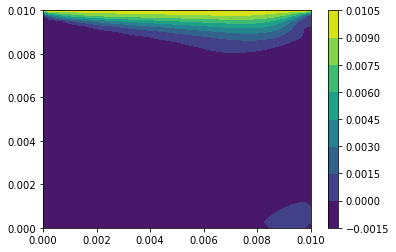

In [29]:
cl = plt.contourf(x, y, exchange_rows(U))
plt.colorbar(cl)
plt.show()